# **Activity Agent**

The activity agent will be responsible for predicting the user's activity for a given day. It will produce activity probabilities for the given user and the given day on an hourly level. These hourly activity probabilities will be processed by the subsequent recommendation agent to determine for which hours our framework should make recommendations. As input the activity agent receives the prepared data from the preparation agent.

We will define an activity agent class, add necessary functions to the agent, explain each step and build our final activity agent pipeline. A complete activity agent class definition will be available in the appendix to this notebook.

## **1. Preparing the Environment**

### **1.1 Loading the Libraries and the Data**

Steps to set up the environment for the activity agent include mounting a Google Drive, loading the necessary libraries, data and preceding agents.


In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

#DATA_PATH = '/content/drive/MyDrive/T4_Recommendation-system-for-demand-response-and-load-shifting/02_data/'

# loading .py scripts of prior agents and helper functions
#!cp /content/drive/MyDrive/T4_Recommendation-system-for-demand-response-and-load-shifting/03_scripts/helper_functions.py #.
#!cp /content/drive/MyDrive/T4_Recommendation-system-for-demand-response-and-load-shifting/03_scripts/agents.py .

In [51]:
# More ML Models
import sklearn as sk 
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [2]:
import sys
sys.path.append('../agents/')
sys.path.append('../02_data/')

In [3]:
# loading necessary libraries
import pandas as pd
import numpy as np

from Helper import Helper
from PreparationAgent import Preparation_Agent


In [4]:
helper = Helper()

In [5]:
DATA_PATH = '../02_data/'

In [6]:
# load household data
household = helper.load_household(DATA_PATH, 1)

In [7]:
household.head()

,Time,Unix,Aggregate,Fridge,Chest Freezer,Upright Freezer,Tumble Dryer,Washing Machine,Dishwasher,Computer Site,Television Site,Electric Heater,Issues
Time,,,,,,,,,,,,,
2013-10-09 13:06:17,2013-10-09 13:06:17,1381323977,523,74,0,69,0,0,0,0,0,1,0
2013-10-09 13:06:31,2013-10-09 13:06:31,1381323991,526,75,0,69,0,0,0,0,0,1,0
2013-10-09 13:06:46,2013-10-09 13:06:46,1381324006,540,74,0,68,0,0,0,0,0,1,0
2013-10-09 13:07:01,2013-10-09 13:07:01,1381324021,532,74,0,68,0,0,0,0,0,1,0
2013-10-09 13:07:15,2013-10-09 13:07:15,1381324035,540,74,0,69,0,0,0,0,0,1,0


### **1.2 Calling the Preparation Agent**

To receive the necessary input for the activity agent, we will call the activity pipeline function of the preparation agent. We will specify the input data and the necessary configurations. As a quick validation that the preparation pipeline worked properly, we will plot the hourly activity of the household.

The current input data includes only a few time features and activity lags. However, our agent architecture allows to expand the inputs to the activity agent to further features or further data sources (e.g. whether data). For the purpose of demonstrating the functionality of our framework, we only use the inputs from the prepared REFIT data. 


In [8]:
truncation_params = {
    'features': 'all', 
    'factor': 1.5, 
    'verbose': 1
}

scale_params = {
    'features': 'all', 
    'kind': 'MinMax', 
    'verbose': 1
}

aggregate_params = {
    'resample_param': '60T'
}

activity_params = {
    'active_appliances': ['Tumble Dryer', 'Washing Machine', 'Dishwasher', 'Computer Site', 'Television Site'],
    'threshold': .15
}

time_params = {
    'features': ['hour', 'day_name']
}

activity_lag_params = {
    'features': ['activity'],
    'lags': [24, 48, 72]
}

activity_pipe_params = {
    'truncate': truncation_params,
    'scale': scale_params,
    'aggregate': aggregate_params,
    'activity': activity_params,
    'time': time_params,
    'activity_lag': activity_lag_params
}

In [9]:
# calling the preparation pipeline
prep = Preparation_Agent(household)
df = prep.pipeline_activity(household, activity_pipe_params)

[outlier truncation: Unix]: 100%|██████████| 6960008/6960008 [00:09<00:00, 698699.46it/s]
[outlier truncation: Unix]: 0 outliers were truncated.


[outlier truncation: Aggregate]: 100%|██████████| 6959964/6959964 [00:08<00:00, 856151.89it/s]
[outlier truncation: Aggregate]: 853913 outliers were truncated.


[outlier truncation: Fridge]: 100%|██████████| 1611328/1611328 [00:02<00:00, 711413.17it/s]
[outlier truncation: Fridge]: 60120 outliers were truncated.


[outlier truncation: Chest Freezer]: 100%|██████████| 2395354/2395354 [00:02<00:00, 892354.76it/s] 
[outlier truncation: Chest Freezer]: 207420 outliers were truncated.


[outlier truncation: Upright Freezer]: 100%|██████████| 2800342/2800342 [00:02<00:00, 966175.20it/s]
[outlier truncation: Upright Freezer]: 197818 outliers were truncated.


[outlier truncation: Tumble Dryer]: 100%|██████████| 28117/28117 [00:00<00:00, 896270.30it/s]
[outlier truncation: Tumble Dryer]: 5934 outliers were truncated.


[outlier truncation: Washing 

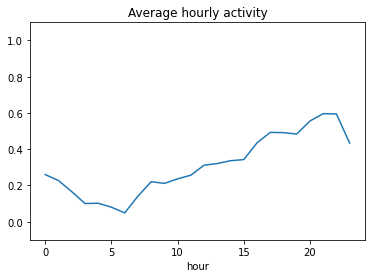

In [10]:
import matplotlib.pyplot as plt

df.groupby(by='hour').mean()['activity'].plot();
plt.title('Average hourly activity')
plt.ylim(-0.1, 1.1);


## **2. Creating the Activity Agent**

In [11]:
class Activity_Agent:

    def __init__(self, activity_input_df):
        self.input = activity_input_df

### **2.1 Train Test Split**

As our recommendation framework will provide recommendations for a given day, our activity agent must be able to provide activity predictions for each day. However, for each day to be predicted we are only allowed to use information from the past to prevent leakage. Therefore, we will create a custom train test split function to meet the time series requirements. 

Our train test split function will enable us to conveniently split our data in the train and test data sets for each day to be predicted while allowing for further configurations of the split (i.e. size of the train and test data sets).

**X_test**

In [12]:
def get_Xtest(self, df, date, time_delta='all', target='activity'):
    import pandas as pd
    from Helper import Helper

    helper = Helper()
    
    if time_delta == 'all':
        output = df.loc[pd.to_datetime(date):, df.columns != target]
    else:
        df = helper.get_timespan(df, date, time_delta)
        output = df.loc[:, df.columns != target]
    return output

# add to Activity agent
setattr(Activity_Agent, 'get_Xtest', get_Xtest)
del get_Xtest

In [13]:
date = '2014-01-01'
activity = Activity_Agent(df)
X_test = activity.get_Xtest(df, date)
X_test

,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
Time,,,,,,,,,,
2014-01-01 00:00:00,0,0.0,1.0,1.0,0,0,0,0,0,1
2014-01-01 01:00:00,1,1.0,1.0,0.0,0,0,0,0,0,1
2014-01-01 02:00:00,2,1.0,0.0,1.0,0,0,0,0,0,1
2014-01-01 03:00:00,3,1.0,0.0,0.0,0,0,0,0,0,1
2014-01-01 04:00:00,4,0.0,1.0,0.0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2015-07-10 07:00:00,7,0.0,0.0,0.0,0,0,0,0,0,0
2015-07-10 08:00:00,8,0.0,0.0,0.0,0,0,0,0,0,0
2015-07-10 09:00:00,9,0.0,0.0,0.0,0,0,0,0,0,0


In [14]:
date = '2014-01-01'
activity = Activity_Agent(df)
time_delta = {'days': 1, 'seconds': -1}
X_test = activity.get_Xtest(df, date, time_delta=time_delta)
X_test

,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
Time,,,,,,,,,,
2014-01-01 00:00:00,0,0.0,1.0,1.0,0,0,0,0,0,1
2014-01-01 01:00:00,1,1.0,1.0,0.0,0,0,0,0,0,1
2014-01-01 02:00:00,2,1.0,0.0,1.0,0,0,0,0,0,1
2014-01-01 03:00:00,3,1.0,0.0,0.0,0,0,0,0,0,1
2014-01-01 04:00:00,4,0.0,1.0,0.0,0,0,0,0,0,1
2014-01-01 05:00:00,5,1.0,0.0,0.0,0,0,0,0,0,1
2014-01-01 06:00:00,6,0.0,0.0,0.0,0,0,0,0,0,1
2014-01-01 07:00:00,7,0.0,1.0,0.0,0,0,0,0,0,1
2014-01-01 08:00:00,8,0.0,1.0,0.0,0,0,0,0,0,1


In [15]:
date = '2014-01-01'
activity = Activity_Agent(df)
time_delta = {'days': 7, 'seconds': -1}
X_test = activity.get_Xtest(df, date, time_delta=time_delta)
X_test

,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
Time,,,,,,,,,,
2014-01-01 00:00:00,0,0.0,1.0,1.0,0,0,0,0,0,1
2014-01-01 01:00:00,1,1.0,1.0,0.0,0,0,0,0,0,1
2014-01-01 02:00:00,2,1.0,0.0,1.0,0,0,0,0,0,1
2014-01-01 03:00:00,3,1.0,0.0,0.0,0,0,0,0,0,1
2014-01-01 04:00:00,4,0.0,1.0,0.0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2014-01-07 19:00:00,19,1.0,1.0,1.0,0,0,0,0,1,0
2014-01-07 20:00:00,20,1.0,1.0,1.0,0,0,0,0,1,0
2014-01-07 21:00:00,21,1.0,1.0,1.0,0,0,0,0,1,0


**y_test**

In [18]:
def get_ytest(self, df, date, time_delta='all', target='activity'):
    import pandas as pd
    from Helper import Helper

    helper = Helper()
    
    if time_delta == 'all':
        output = df.loc[pd.to_datetime(date):, target]
    else:
        output = helper.get_timespan(df, date, time_delta)[target]
    return output

# add to Activity agent
setattr(Activity_Agent, 'get_ytest', get_ytest)
del get_ytest

In [19]:
date = '2014-01-01'
activity = Activity_Agent(df)
y_test = activity.get_ytest(df, date)
y_test

Time
2014-01-01 00:00:00    1
2014-01-01 01:00:00    0
2014-01-01 02:00:00    1
2014-01-01 03:00:00    1
2014-01-01 04:00:00    1
                      ..
2015-07-10 07:00:00    0
2015-07-10 08:00:00    0
2015-07-10 09:00:00    0
2015-07-10 10:00:00    0
2015-07-10 11:00:00    0
Freq: 60T, Name: activity, Length: 13332, dtype: int64

In [20]:
date = '2014-01-01'

activity = Activity_Agent(df)
time_delta = {'days': 7, 'seconds': -1}

y_test = activity.get_ytest(df, date, time_delta=time_delta)
y_test

Time
2014-01-01 00:00:00    1
2014-01-01 01:00:00    0
2014-01-01 02:00:00    1
2014-01-01 03:00:00    1
2014-01-01 04:00:00    1
                      ..
2014-01-07 19:00:00    0
2014-01-07 20:00:00    1
2014-01-07 21:00:00    1
2014-01-07 22:00:00    1
2014-01-07 23:00:00    1
Freq: 60T, Name: activity, Length: 168, dtype: int64

**X_train**

In [21]:
# start = int (e.g. -100) --> 100 days before the day to be predicted will represent the train data
def get_Xtrain(self, df, date, start='2013-11-01', target='activity'):
    import pandas as pd

    if type(start) == int:
        start = pd.to_datetime(date) + pd.Timedelta(days= start)
        start = pd.to_datetime('2013-11-01') if start < pd.to_datetime('2013-11-01') else start
    else:
        start = pd.to_datetime(start)
    end = pd.to_datetime(date) + pd.Timedelta(seconds=-1)
    return df.loc[start:end, df.columns != target]

# add to Activity agent
setattr(Activity_Agent, 'get_Xtrain', get_Xtrain)
del get_Xtrain

In [22]:
date = '2014-01-01'

activity = Activity_Agent(df)
X_train = activity.get_Xtrain(df, date)
X_train

,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
Time,,,,,,,,,,
2013-11-01 00:00:00,0,1.0,0.0,0.0,0,0,0,0,0,0
2013-11-01 01:00:00,1,1.0,1.0,0.0,0,0,0,0,0,0
2013-11-01 02:00:00,2,0.0,0.0,1.0,0,0,0,0,0,0
2013-11-01 03:00:00,3,0.0,0.0,1.0,0,0,0,0,0,0
2013-11-01 04:00:00,4,1.0,0.0,0.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,19,1.0,1.0,1.0,0,0,0,0,1,0
2013-12-31 20:00:00,20,1.0,1.0,1.0,0,0,0,0,1,0
2013-12-31 21:00:00,21,1.0,1.0,0.0,0,0,0,0,1,0


In [23]:
date = '2014-01-01'

activity = Activity_Agent(df)
X_train = activity.get_Xtrain(df, date, start=-1)
X_train

,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
Time,,,,,,,,,,
2013-12-31 00:00:00,0,1.0,1.0,0.0,0,0,0,0,1,0
2013-12-31 01:00:00,1,1.0,0.0,1.0,0,0,0,0,1,0
2013-12-31 02:00:00,2,0.0,1.0,1.0,0,0,0,0,1,0
2013-12-31 03:00:00,3,0.0,0.0,0.0,0,0,0,0,1,0
2013-12-31 04:00:00,4,1.0,0.0,1.0,0,0,0,0,1,0
2013-12-31 05:00:00,5,0.0,0.0,0.0,0,0,0,0,1,0
2013-12-31 06:00:00,6,0.0,0.0,0.0,0,0,0,0,1,0
2013-12-31 07:00:00,7,1.0,0.0,0.0,0,0,0,0,1,0
2013-12-31 08:00:00,8,1.0,0.0,0.0,0,0,0,0,1,0


In [24]:
date = '2014-01-01'

activity = Activity_Agent(df)
X_train = activity.get_Xtrain(df, date, start=-10)
X_train

,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
Time,,,,,,,,,,
2013-12-22 00:00:00,0,0.0,0.0,1.0,0,0,1,0,0,0
2013-12-22 01:00:00,1,0.0,0.0,1.0,0,0,1,0,0,0
2013-12-22 02:00:00,2,1.0,0.0,0.0,0,0,1,0,0,0
2013-12-22 03:00:00,3,1.0,0.0,1.0,0,0,1,0,0,0
2013-12-22 04:00:00,4,0.0,0.0,0.0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,19,1.0,1.0,1.0,0,0,0,0,1,0
2013-12-31 20:00:00,20,1.0,1.0,1.0,0,0,0,0,1,0
2013-12-31 21:00:00,21,1.0,1.0,0.0,0,0,0,0,1,0


In [25]:
date = '2014-01-01'

activity = Activity_Agent(df)
X_train = activity.get_Xtrain(df, date, start=-9999)
X_train

,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
Time,,,,,,,,,,
2013-11-01 00:00:00,0,1.0,0.0,0.0,0,0,0,0,0,0
2013-11-01 01:00:00,1,1.0,1.0,0.0,0,0,0,0,0,0
2013-11-01 02:00:00,2,0.0,0.0,1.0,0,0,0,0,0,0
2013-11-01 03:00:00,3,0.0,0.0,1.0,0,0,0,0,0,0
2013-11-01 04:00:00,4,1.0,0.0,0.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,19,1.0,1.0,1.0,0,0,0,0,1,0
2013-12-31 20:00:00,20,1.0,1.0,1.0,0,0,0,0,1,0
2013-12-31 21:00:00,21,1.0,1.0,0.0,0,0,0,0,1,0


**y_train**

In [26]:
def get_ytrain(self, df, date, start='2013-11-01', target='activity'):
    import pandas as pd

    if type(start) == int:
        start = pd.to_datetime(date) + pd.Timedelta(days= start)
        start = pd.to_datetime('2013-11-01') if start < pd.to_datetime('2013-11-01') else start
    else:
        start = pd.to_datetime(start)
    end = pd.to_datetime(date) + pd.Timedelta(seconds=-1)
    return df.loc[start:end, target]

# add to Activity agent
setattr(Activity_Agent, 'get_ytrain', get_ytrain)
del get_ytrain

In [27]:
date = '2014-01-01'
activity = Activity_Agent(df)
y_train = activity.get_ytrain(df, date)
y_train

Time
2013-11-01 00:00:00    0
2013-11-01 01:00:00    0
2013-11-01 02:00:00    0
2013-11-01 03:00:00    0
2013-11-01 04:00:00    0
                      ..
2013-12-31 19:00:00    1
2013-12-31 20:00:00    1
2013-12-31 21:00:00    1
2013-12-31 22:00:00    1
2013-12-31 23:00:00    1
Freq: 60T, Name: activity, Length: 1464, dtype: int64

In [28]:
date = '2014-01-01'
activity = Activity_Agent(df)
y_train = activity.get_ytrain(df, date, start=-1)
y_train

Time
2013-12-31 00:00:00    0
2013-12-31 01:00:00    1
2013-12-31 02:00:00    1
2013-12-31 03:00:00    1
2013-12-31 04:00:00    0
2013-12-31 05:00:00    1
2013-12-31 06:00:00    0
2013-12-31 07:00:00    0
2013-12-31 08:00:00    0
2013-12-31 09:00:00    0
2013-12-31 10:00:00    0
2013-12-31 11:00:00    0
2013-12-31 12:00:00    1
2013-12-31 13:00:00    1
2013-12-31 14:00:00    1
2013-12-31 15:00:00    1
2013-12-31 16:00:00    1
2013-12-31 17:00:00    1
2013-12-31 18:00:00    1
2013-12-31 19:00:00    1
2013-12-31 20:00:00    1
2013-12-31 21:00:00    1
2013-12-31 22:00:00    1
2013-12-31 23:00:00    1
Freq: 60T, Name: activity, dtype: int64

In [29]:
date = '2014-01-01'
activity = Activity_Agent(df)
y_train = activity.get_ytrain(df, date, start=-10)
y_train

Time
2013-12-22 00:00:00    1
2013-12-22 01:00:00    0
2013-12-22 02:00:00    1
2013-12-22 03:00:00    0
2013-12-22 04:00:00    1
                      ..
2013-12-31 19:00:00    1
2013-12-31 20:00:00    1
2013-12-31 21:00:00    1
2013-12-31 22:00:00    1
2013-12-31 23:00:00    1
Freq: 60T, Name: activity, Length: 240, dtype: int64

In [30]:
date = '2014-01-01'
activity = Activity_Agent(df)
y_train = activity.get_ytrain(df, date, start=-9999)
y_train

Time
2013-11-01 00:00:00    0
2013-11-01 01:00:00    0
2013-11-01 02:00:00    0
2013-11-01 03:00:00    0
2013-11-01 04:00:00    0
                      ..
2013-12-31 19:00:00    1
2013-12-31 20:00:00    1
2013-12-31 21:00:00    1
2013-12-31 22:00:00    1
2013-12-31 23:00:00    1
Freq: 60T, Name: activity, Length: 1464, dtype: int64

**train_test_split**

In [31]:
def train_test_split(self, df, date, train_start='2013-11-01', test_delta='all', target='activity'):
    X_train = self.get_Xtrain(df, date, start=train_start, target=target)
    y_train = self.get_ytrain(df, date, start=train_start, target=target)
    X_test = self.get_Xtest(df, date, time_delta=test_delta, target=target)
    y_test = self.get_ytest(df, date, time_delta=test_delta, target=target)
    return X_train, y_train, X_test, y_test

# add to Activity agent
setattr(Activity_Agent, 'train_test_split', train_test_split)
del train_test_split    

In [32]:
date = '2014-01-01'
activity = Activity_Agent(df)
X_train, y_train, X_test, y_test = activity.train_test_split(df, date)
df.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((15335, 11), (1464, 10), (1464,), (13332, 10), (13332,))

In [33]:
date = '2014-01-01'
activity = Activity_Agent(df)
X_train, y_train, X_test, y_test = activity.train_test_split(df, date, train_start=-10, test_delta={'days': 10, 'seconds':-1})
df.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((15335, 11), (240, 10), (240,), (240, 10), (240,))

In [34]:
date = '2014-01-01'
activity = Activity_Agent(df)
X_train, y_train, X_test, y_test = activity.train_test_split(df, date, test_delta={'days': 1, 'seconds':-1})
df.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((15335, 11), (1464, 10), (1464,), (24, 10), (24,))

In [35]:
X_train

,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
Time,,,,,,,,,,
2013-11-01 00:00:00,0,1.0,0.0,0.0,0,0,0,0,0,0
2013-11-01 01:00:00,1,1.0,1.0,0.0,0,0,0,0,0,0
2013-11-01 02:00:00,2,0.0,0.0,1.0,0,0,0,0,0,0
2013-11-01 03:00:00,3,0.0,0.0,1.0,0,0,0,0,0,0
2013-11-01 04:00:00,4,1.0,0.0,0.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,19,1.0,1.0,1.0,0,0,0,0,1,0
2013-12-31 20:00:00,20,1.0,1.0,1.0,0,0,0,0,1,0
2013-12-31 21:00:00,21,1.0,1.0,0.0,0,0,0,0,1,0


In [36]:
X_test

,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
Time,,,,,,,,,,
2014-01-01 00:00:00,0,0.0,1.0,1.0,0,0,0,0,0,1
2014-01-01 01:00:00,1,1.0,1.0,0.0,0,0,0,0,0,1
2014-01-01 02:00:00,2,1.0,0.0,1.0,0,0,0,0,0,1
2014-01-01 03:00:00,3,1.0,0.0,0.0,0,0,0,0,0,1
2014-01-01 04:00:00,4,0.0,1.0,0.0,0,0,0,0,0,1
2014-01-01 05:00:00,5,1.0,0.0,0.0,0,0,0,0,0,1
2014-01-01 06:00:00,6,0.0,0.0,0.0,0,0,0,0,0,1
2014-01-01 07:00:00,7,0.0,1.0,0.0,0,0,0,0,0,1
2014-01-01 08:00:00,8,0.0,1.0,0.0,0,0,0,0,0,1


In [37]:
y_train

Time
2013-11-01 00:00:00    0
2013-11-01 01:00:00    0
2013-11-01 02:00:00    0
2013-11-01 03:00:00    0
2013-11-01 04:00:00    0
                      ..
2013-12-31 19:00:00    1
2013-12-31 20:00:00    1
2013-12-31 21:00:00    1
2013-12-31 22:00:00    1
2013-12-31 23:00:00    1
Freq: 60T, Name: activity, Length: 1464, dtype: int64

In [38]:
y_test

Time
2014-01-01 00:00:00    1
2014-01-01 01:00:00    0
2014-01-01 02:00:00    1
2014-01-01 03:00:00    1
2014-01-01 04:00:00    1
2014-01-01 05:00:00    0
2014-01-01 06:00:00    0
2014-01-01 07:00:00    0
2014-01-01 08:00:00    1
2014-01-01 09:00:00    1
2014-01-01 10:00:00    0
2014-01-01 11:00:00    0
2014-01-01 12:00:00    1
2014-01-01 13:00:00    1
2014-01-01 14:00:00    1
2014-01-01 15:00:00    1
2014-01-01 16:00:00    1
2014-01-01 17:00:00    1
2014-01-01 18:00:00    1
2014-01-01 19:00:00    0
2014-01-01 20:00:00    1
2014-01-01 21:00:00    1
2014-01-01 22:00:00    1
2014-01-01 23:00:00    0
Freq: 60T, Name: activity, dtype: int64

### **2.2 Building Models**

Within this section, we will demonstrate how different models for predicting the user activity could be added to the activity agent. For this notebook, we chose to implement a pretty simple logistic regression using the statsmodel api which already provides promising results. 

The functionality of the activity agent will include building models, fitting models and predicting the user’s activity.


In [132]:
### Extend that function to more models 
def fit_smLogit(self, X, y):
    import statsmodels.api as sm
    return sm.Logit(y, X).fit(disp=False)

# add to Activity agent
setattr(Activity_Agent, 'fit_smLogit', fit_smLogit)
del fit_smLogit 

In [108]:
def skModels(self,model, X, y):
        # models we want to try
        names = ["knn", "linear svm", 
        "rbv svm", "gaussian process","descision tree", "random forest", 
        "nn", "ada boost","nb", "qda", 'logit']
        classifiers = [ KNeighborsClassifier(3),
                        SVC(kernel="linear", C=0.025),
                        SVC(gamma=2, C=1),
                        GaussianProcessClassifier(1.0 * RBF(1.0)),
                        DecisionTreeClassifier(max_depth=5),
                        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
                        MLPClassifier(alpha=1, max_iter=1000),
                        AdaBoostClassifier(),
                        GaussianNB(),
                        QuadraticDiscriminantAnalysis()]
        model_types = [type(classifier) for classifier in classifiers]
        if model in names:
            dict_of_classifiers = dict(zip(names, classifiers))
            return  dict_of_classifiers, model_types   
        else:
            raise InputError('Unknown model type.')
setattr(Activity_Agent, 'skModels', skModels)
del skModels

In [109]:
activity = Activity_Agent(df)
dict_, model_types = activity.skModels('knn', X_train, y_train)

In [110]:
model_types

[sklearn.neighbors._classification.KNeighborsClassifier,
 sklearn.svm._classes.SVC,
 sklearn.svm._classes.SVC,
 sklearn.gaussian_process._gpc.GaussianProcessClassifier,
 sklearn.tree._classes.DecisionTreeClassifier,
 sklearn.ensemble._forest.RandomForestClassifier,
 sklearn.neural_network._multilayer_perceptron.MLPClassifier,
 sklearn.ensemble._weight_boosting.AdaBoostClassifier,
 sklearn.naive_bayes.GaussianNB,
 sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis]

In [124]:
def fit_skModels(self, model_type, X,y):
    if model_type in dict_:
        fitted_model = dict_[model_type].fit(X,y)
        return fitted_model
    else:
        raise InputError('Unknown model type')
        
setattr(Activity_Agent, 'fit_skModels', fit_skModels)
del fit_skModels

In [125]:
activity = Activity_Agent(df)
skmodel = activity.fit_skModels('linear svm',X_train, y_train)


In [153]:
def skModels_predict(self, model, X):
    import sklearn
    types = [sklearn.neighbors._classification.KNeighborsClassifier,
            sklearn.svm._classes.SVC,
            sklearn.svm._classes.SVC,
            sklearn.gaussian_process._gpc.GaussianProcessClassifier,
            sklearn.tree._classes.DecisionTreeClassifier,
            sklearn.ensemble._forest.RandomForestClassifier,
            sklearn.neural_network._multilayer_perceptron.MLPClassifier,
            sklearn.ensemble._weight_boosting.AdaBoostClassifier,
            sklearn.naive_bayes.GaussianNB,
            sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis]
    if type(model) in types:
        y_hat = model.predict(X)
        y_hat = pd.Series(y_hat, index=X.index, name='Time')
    else:
        raise InputError('Unknown model type.')
    return y_hat

# add to Activity agent
setattr(Activity_Agent, 'skModels_predict', skModels_predict)
del skModels_predict

In [154]:
activity = Activity_Agent(df)
y_hat = activity.skModels_predict(model, X_test)
y_hat

NameError: name 'InputError' is not defined

In [141]:
def fit(self, X, y, model_type):
    if model_type =='logit':
        model = self.fit_smLogit(X, y)
    else:
        raise InputError('Unknown model type.')
    return model

# add to Activity agent
setattr(Activity_Agent, 'fit', fit)
del fit

In [142]:
activity = Activity_Agent(df)
model = activity.fit(X_train, y_train, 'logit')
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:               activity   No. Observations:                 1464
Model:                          Logit   Df Residuals:                     1454
Method:                           MLE   Df Model:                            9
Date:                Mon, 24 May 2021   Pseudo R-squ.:                 0.01509
Time:                        15:32:17   Log-Likelihood:                -916.42
converged:                       True   LL-Null:                       -930.46
Covariance Type:            nonrobust   LLR p-value:                 0.0009241
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
hour                   0.0249      0.008      3.157      0.002       0.009       0.040
activity_lag_24        0.5104      0.123      4.144      0.000       0.269       0.752
activity_lag_48     

In [144]:
def predict(self, model, X):
    import statsmodels

    if type(model) == statsmodels.discrete.discrete_model.BinaryResultsWrapper:
        y_hat = model.predict(X)
    else:
        raise InputError('Unknown model type.')
    return y_hat

# add to Activity agent
setattr(Activity_Agent, 'predict', predict)
del predict

In [146]:
activity = Activity_Agent(df)
y_hat = activity.predict(model, X_test)
len(y_hat)

24

### **2.3 Model Evaluation**

A drawback to our approach is that we are not able to apply conventional model evaluation techniques to our model. We will train our model for each day to account for newly available information. Hence, we have different train and test sets for each day and for each day different performance metric based on the respective data sets. Therefore, we created our own evaluation function. 

Our evaluation function will build a model, fit the model and predict the target for each day for a given prediction period. For each day and fitted model it will calculate a performance metric on the train data. We chose the Area Under the Receiver Operating Characteristic Curve (AUC) as performance metric for our binary classification task. As in our case the test data is only the current date to be predicted (i.e. 24 data cases in the test data, one for each hour of the day), calculating the AUC on the test date immediately would lead to a high volatility in the test AUC per day to be predicted. Therefore, we calculate the test AUC over the activity probabilities of all days after all days have been predicted. To summarize the train AUC in one score, we apply an average over all calculated train AUC scores.

In [118]:
def auc(self, y_true, y_hat):
    import sklearn.metrics
    return sklearn.metrics.roc_auc_score(y_true, y_hat)

# add to Activity agent
setattr(Activity_Agent, 'auc', auc)
del auc

In [121]:
def evaluate(self, df, model_type, split_params, predict_start='2014-01-01', predict_end=-1):
    import pandas as pd
    import numpy as np
    from tqdm import tqdm

    dates = pd.DataFrame(df.index).set_index(df.index)['Time'].apply(lambda date: str(date)[:10]).drop_duplicates()

    predict_start = pd.to_datetime(predict_start)
    predict_end = pd.to_datetime(dates[predict_end]) if type(predict_end) == int else pd.to_datetime(predict_end)

    dates = dates.loc[predict_start:predict_end]
    
    y_true = []
    y_hat_train = {}
    y_hat_test = []
    auc_train_dict = {}
    auc_test = []

    for date in tqdm(dates):
        # train test split
        #train_test_split(self, df, date, train_start='2013-11-01', test_delta='all', target='activity')
        X_train, y_train, X_test, y_test = self.train_test_split(df, date, **split_params)

        # fit model
        model = self.fit_skModels(X_train, y_train, model_type)

        # predict
        y_hat_train.update({date: self.skModels_predict(model, X_train)})
        y_hat_test += list(self.skModels_predict(model, X_test))

        # evaluate train data
        auc_train_dict.update({date: self.auc(y_train, list(y_hat_train.values())[-1])})
        
        y_true += list(y_test)
    
    auc_test = self.auc(y_true, y_hat_test)
    auc_train = np.mean(list(auc_train_dict.values()))

    return auc_train, auc_test, auc_train_dict


# add to Activity agent
setattr(Activity_Agent, 'evaluate', evaluate)
del evaluate

In [123]:
split_params = {'train_start': '2013-11-01', 'test_delta': {'days':1, 'seconds':-1}, 'target': 'activity'}
activity = Activity_Agent(df)
auc_train, auc_test, auc_train_dict = activity.evaluate(df, 'knn', split_params) 

  0%|          | 0/556 [00:00<?, ?it/s]


TypeError: 'DataFrame' objects are mutable, thus they cannot be hashed

In [41]:
# printing the scores
print(f'[model performance] train auc score: {auc_train}\n[model performance] test auc score: {auc_test}')

[model performance] train auc score: 0.7170171425589704
[model performance] test auc score: 0.7193890335654205


### **2.4 Pipeline Function**

The pipeline function of the activity agent will receive a date as input, create the appropriate train test split, fit the selected model to the data and return the activity predictions for the day to be predicted. The subsequent recommendation agent will process these activity probabilities to provide recommendations to the user.

In [42]:
def pipeline(self, df, date, model_type, split_params):
    X_train, y_train, X_test, y_test = self.train_test_split(df, date, **split_params)

    # fit model
    model = self.fit(X_train, y_train, model_type)

    # predict
    return self.predict(model, X_test)

# add to Activity agent
setattr(Activity_Agent, 'pipeline', pipeline)
del pipeline

In [48]:
activity = Activity_Agent(df)

date = '2014-06-01'
split_params = {'train_start': '2013-11-01', 'test_delta': {'days':1, 'seconds':-1}, 'target': 'activity'}

output = activity.pipeline(df, date, 'logit', split_params)
output

Time
2014-06-01 00:00:00    0.295583
2014-06-01 01:00:00    0.292414
2014-06-01 02:00:00    0.289266
2014-06-01 03:00:00    0.176376
2014-06-01 04:00:00    0.174170
2014-06-01 05:00:00    0.171985
2014-06-01 06:00:00    0.169821
2014-06-01 07:00:00    0.250656
2014-06-01 08:00:00    0.247799
2014-06-01 09:00:00    0.396992
2014-06-01 10:00:00    0.393343
2014-06-01 11:00:00    0.544463
2014-06-01 12:00:00    0.540674
2014-06-01 13:00:00    0.363583
2014-06-01 14:00:00    0.654655
2014-06-01 15:00:00    0.651196
2014-06-01 16:00:00    0.647720
2014-06-01 17:00:00    0.644229
2014-06-01 18:00:00    0.487909
2014-06-01 19:00:00    0.637200
2014-06-01 20:00:00    0.633663
2014-06-01 21:00:00    0.476474
2014-06-01 22:00:00    0.502597
2014-06-01 23:00:00    0.498780
Freq: 60T, dtype: float64

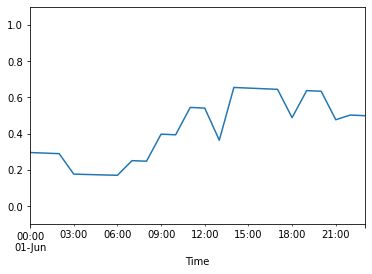

In [49]:
output.plot();
plt.ylim(-.1, 1.1);

## **Appendix A1: Complete Activity Agent**

In [45]:
class Activity_Agent:


    def __init__(self, activity_input_df):
        self.input = activity_input_df


    def get_Xtest(self, df, date, time_delta='all', target='activity'):
        import pandas as pd
        from helper_functions import Helper

        helper = Helper()
    
        if time_delta == 'all':
            output = df.loc[pd.to_datetime(date):, df.columns != target]
        else:
            df = helper.get_timespan(df, date, time_delta)
            output = df.loc[:, df.columns != target]
        return output


    def get_ytest(self, df, date, time_delta='all', target='activity'):
        import pandas as pd
        from helper_functions import Helper

        helper = Helper()
    
        if time_delta == 'all':
            output = df.loc[pd.to_datetime(date):, target]
        else:
            output = helper.get_timespan(df, date, time_delta)[target]
        return output


    def get_Xtrain(self, df, date, start='2013-11-01', target='activity'):
        import pandas as pd

        if type(start) == int:
            start = pd.to_datetime(date) + pd.Timedelta(days= start)
            start = pd.to_datetime('2013-11-01') if start < pd.to_datetime('2013-11-01') else start
        else:
            start = pd.to_datetime(start)
        end = pd.to_datetime(date) + pd.Timedelta(seconds=-1)
        return df.loc[start:end, df.columns != target]


    def get_ytrain(self, df, date, start='2013-11-01', target='activity'):
        import pandas as pd

        if type(start) == int:
            start = pd.to_datetime(date) + pd.Timedelta(days= start)
            start = pd.to_datetime('2013-11-01') if start < pd.to_datetime('2013-11-01') else start
        else:
            start = pd.to_datetime(start)
        end = pd.to_datetime(date) + pd.Timedelta(seconds=-1)
        return df.loc[start:end, target]


    def train_test_split(self, df, date, train_start='2013-11-01', test_delta='all', target='activity'):
        X_train = self.get_Xtrain(df, date, start=train_start, target=target)
        y_train = self.get_ytrain(df, date, start=train_start, target=target)
        X_test = self.get_Xtest(df, date, time_delta=test_delta, target=target)
        y_test = self.get_ytest(df, date, time_delta=test_delta, target=target)
        return X_train, y_train, X_test, y_test


    def fit_smLogit(self, X, y):
        import statsmodels.api as sm
        return sm.Logit(y, X).fit(disp=False)


    def fit(self, X, y, model_type):
        if model_type == 'logit':
            model = self.fit_smLogit(X, y)
        else:
            raise InputError('Unknown model type.')
        return model


    def predict(self, model, X):
        import statsmodels

        if type(model) == statsmodels.discrete.discrete_model.BinaryResultsWrapper:
            y_hat = model.predict(X)
        else:
            raise InputError('Unknown model type.')
        return y_hat


    def auc(self, y_true, y_hat):
        import sklearn.metrics
        return sklearn.metrics.roc_auc_score(y_true, y_hat)


    def evaluate(self, df, model_type, split_params, predict_start='2014-01-01', predict_end=-1):
        import pandas as pd
        import numpy as np
        from tqdm import tqdm

        dates = pd.DataFrame(df.index).set_index(df.index)['Time'].apply(lambda date: str(date)[:10]).drop_duplicates()

        predict_start = pd.to_datetime(predict_start)
        predict_end = pd.to_datetime(dates[predict_end]) if type(predict_end) == int else pd.to_datetime(predict_end)

        dates = dates.loc[predict_start:predict_end]
    
        y_true = []
        y_hat_train = {}
        y_hat_test = []
        auc_train_dict = {}
        auc_test = []

        for date in tqdm(dates):
            # train test split
            #train_test_split(self, df, date, train_start='2013-11-01', test_delta='all', target='activity')
            X_train, y_train, X_test, y_test = self.train_test_split(df, date, **split_params)

            # fit model
            model = self.fit(X_train, y_train, model_type)

            # predict
            y_hat_train.update({date: self.predict(model, X_train)})
            y_hat_test += list(self.predict(model, X_test))

            # evaluate train data
            auc_train_dict.update({date: self.auc(y_train, list(y_hat_train.values())[-1])})
        
            y_true += list(y_test)
    
        auc_test = self.auc(y_true, y_hat_test)
        auc_train = np.mean(list(auc_train_dict.values()))

        return auc_train, auc_test, auc_train_dict


    def pipeline(self, df, date, model_type, split_params):
        # train test split
        X_train, y_train, X_test, y_test = self.train_test_split(df, date, **split_params)

        # fit model
        model = self.fit(X_train, y_train, model_type)

        # predict
        return self.predict(model, X_test)